In [2]:
# Initialisation model
import sys
import os
import torch
from optimizer import Optimizer
from config import Config
import glob
import tqdm
sys.path.insert(0,'/content/NextFace') # Verify your path

# Load configuration file
config = Config()
config.fillFromDicFile('./optimConfig.ini')
config.device = 'cuda' 
config.path = './baselMorphableModel/' 

# Directory path containing all images

outputDir = './output/debug/'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)  # Create the output directory if it doesn't exist
    
torch.cuda.set_device(0)

c:\Users\dani_\anaconda3\envs\faceNext\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!
loading optim config from:  ./optimConfig.ini


Loading Basel Face Model 2017 from ./baselMorphableModel//morphableModel-2017.pickle...
loading mesh normals...
loading uv parametrization...
loading landmarks association file...
creating sampler...


c:\Users\dani_\anaconda3\envs\faceNext\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading image from path: input/detailled_faces_unsplash/bikerman_256.jpg
detecting landmarks using: fan


c:\Users\dani_\Desktop\repos\NextFace\landmarksfan.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(landmarks, device = self.device)
init camera pose...
1/3 => Optimizing head pose and expressions using landmarks...
100%|██████████| 2000/2000 [00:49<00:00, 40.09it/s]


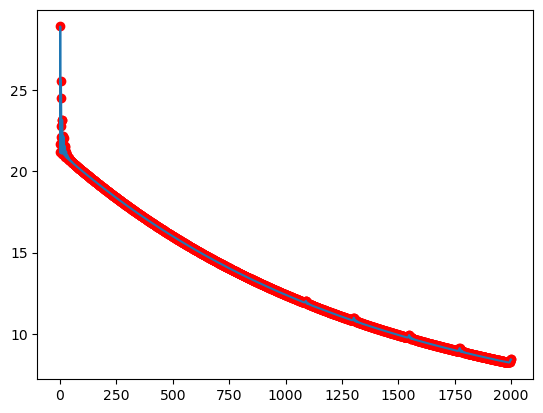

In [3]:
# Create the optimizer and input image
imagePath = "input/detailled_faces_unsplash/bikerman_256.jpg"
optimizer = Optimizer(outputDir, config)

# Choose Mitsuba and set image
optimizer.renderer = "mitsuba"
optimizer.setImage(imagePath, False) # sharedIdentity

# Run the first optimisation
optimizer.runStep1()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


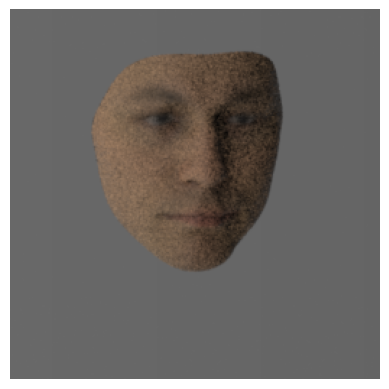

In [4]:
def renderMitsuba(spp=None):
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    
    # Uses the default albedo, specular and roughness from the morphomable model
    vDiffTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    vSpecTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    vRoughTextures = optimizer.pipeline.vRoughness
    
    # Render the image (possible to change the number of spp)
    if spp != None:
        tmpSpp = optimizer.pipeline.renderer.samples
        optimizer.pipeline.renderer.samples = spp
    out = optimizer.pipeline.renderMitsuba(None, vDiffTextures, vSpecTextures, vRoughTextures)
    if spp != None:
        optimizer.pipeline.renderer.samples = tmpSpp
    
    return out

def show(img):
    import matplotlib.pyplot as plt
    plt.axis("off")
    plt.imshow(img ** (1.0 / 2.2))
    
img = renderMitsuba()
show(img.cpu().detach()[0])

In [ ]:
# Now try to compute the variance from the process
inputTensor = torch.pow(optimizer.inputImage.tensor, optimizer.inputImage.gamma)
show(inputTensor.cpu()[0])

100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


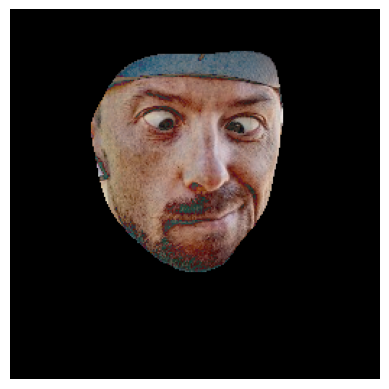

In [5]:
# Learn the lighting and Albedo
parameters_opt = torch.optim.Adam([
    {'params': optimizer.pipeline.vShCoeffs, 'lr': 0.005},
    {'params': optimizer.pipeline.vAlbedoCoeff, 'lr': 0.007}
])

losses = []
for iter in tqdm.tqdm(range(100)):
    parameters_opt.zero_grad() 
    
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    diffuseTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    specularTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    roughTextures = optimizer.pipeline.vRoughness.detach().clone() if optimizer.vEnhancedRoughness is None else optimizer.vEnhancedRoughness.detach().clone()
    # clamp values to not have errors
    diffuseTextures = diffuseTextures.clamp(0,1)
    specularTextures = specularTextures.clamp(0,1)
    roughTextures = roughTextures.clamp(0,1)
    
    # Mitsuba
    rgba_img = optimizer.pipeline.renderMitsuba(cameraVerts, diffuseTextures, specularTextures) #mitsuba
    mask_alpha = optimizer.getMask(cameraVerts, diffAlbedo)
    
    # Compute the difference
    diff = mask_alpha * (rgba_img[..., 0:3] - inputTensor).abs()
    if(iter == 0):
        show(diff.cpu().detach()[0])
    
    # Compute the loss (multiple terms)
    photoLoss = 1000.* diff.mean()
    landmarksLoss = optimizer.config.weightLandmarksLossStep2 *  optimizer.landmarkLoss(cameraVerts, optimizer.landmarks)
    regLoss = 0.0001 * optimizer.pipeline.vShCoeffs.pow(2).mean()
    regLoss += optimizer.config.weightAlbedoReg * optimizer.regStatModel(optimizer.pipeline.vAlbedoCoeff, optimizer.pipeline.morphableModel.diffuseAlbedoPcaVar)
    regLoss += optimizer.config.weightShapeReg * optimizer.regStatModel(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.morphableModel.shapePcaVar)
    regLoss += optimizer.config.weightExpressionReg * optimizer.regStatModel(optimizer.pipeline.vExpCoeff, optimizer.pipeline.morphableModel.expressionPcaVar)

    loss = photoLoss + landmarksLoss + regLoss
    losses.append(loss.item())
    loss.backward()
    
    # Advance optimizer
    parameters_opt.step()

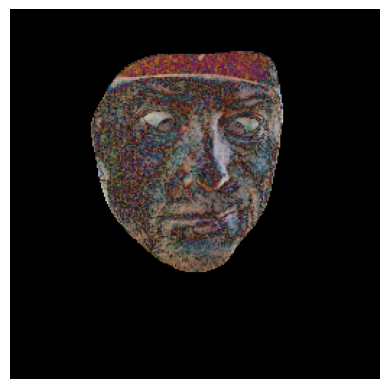

In [6]:
# Last difference
show(diff.cpu().detach()[0])

[49.11201858520508, 47.92424392700195, 46.831146240234375, 45.708370208740234, 44.74420166015625, 43.664302825927734, 42.71125793457031, 41.82516098022461, 40.86180114746094, 40.01496124267578, 39.06515121459961, 38.024574279785156, 37.2677001953125, 36.4844856262207, 35.77527618408203, 34.92775344848633, 34.30069351196289, 33.58094787597656, 32.84943389892578, 32.235450744628906, 31.69797706604004, 31.25776481628418, 30.793615341186523, 30.319231033325195, 29.98891830444336, 29.500425338745117, 29.253231048583984, 29.038738250732422, 28.866165161132812, 28.683231353759766, 28.43630027770996, 28.185623168945312, 28.29597282409668, 28.229280471801758, 28.12403106689453, 27.99237060546875, 28.055631637573242, 27.912433624267578, 27.906152725219727, 27.686073303222656, 27.89423179626465, 27.601058959960938, 27.489681243896484, 27.577404022216797, 27.67993927001953, 27.479656219482422, 27.400880813598633, 27.232688903808594, 27.13793182373047, 26.928756713867188, 27.109249114990234, 27.017

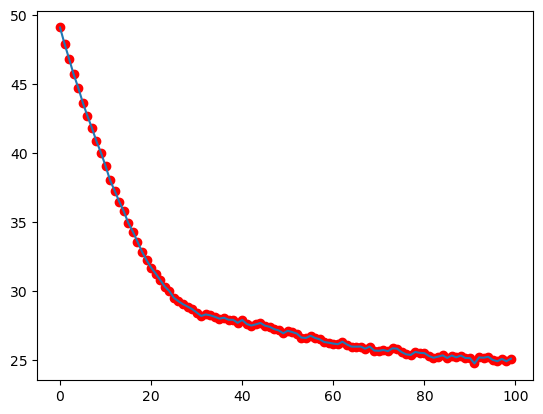

In [7]:
# Show loss 
print(losses)
optimizer.plotLoss(losses, 1, optimizer.outputDir + 'checkpoints/stage2_loss.png')

In [8]:
import matplotlib.pyplot as plt
print("Exp:")
print(optimizer.pipeline.vExpCoeff.cpu().detach())
print("Shape:")
print(optimizer.pipeline.vShapeCoeff.cpu().detach())

Exp:
tensor([[-30.9485,  33.9621,  32.1060, -33.5502,  39.1940, -32.7295,  32.4825,
         -29.7065, -34.5058, -34.2620, -33.1185,  33.5582,  34.2696, -37.0453,
          36.7644, -33.6469, -32.6958,  32.3395,  34.4322,  33.8444, -27.7405,
          34.3505,  15.3083, -25.6668, -37.5989,  19.2857, -34.8344,  14.7126,
          21.0755,  -9.1273, -34.8987, -34.9283, -35.5766,  35.5251,  31.5567,
         -31.9024,  31.7845,  33.5285, -32.8219, -26.8933,  23.0645,  -2.0434,
         -12.2571,  32.6881, -35.0538, -27.8506, -27.5028, -34.4693,  22.8920,
          34.0594, -31.7177,  27.2707,  18.0409, -36.0590,  37.7070,  29.2355,
         -19.2383,  13.0938, -23.9754,  27.6596,  23.6055,  -2.9379,  10.4317,
          25.4131,  31.4165,  30.6684, -33.2665,  32.4580,  -8.1853, -24.5558,
         -33.6390, -16.1200, -27.1306,  24.1159,   9.4712,  22.1699, -29.5321,
         -32.0379,  19.9304, -33.0465,  31.3997,  35.4486,  11.7579,  31.9507,
         -28.4281, -31.0946, -29.8870, -17.6243

In [9]:
# Turn off gradients
optimizer.pipeline.vShCoeffs.requires_grad = False
optimizer.pipeline.vAlbedoCoeff.requires_grad = False

# Turn on gradients for the shape and Exp
optimizer.pipeline.vShapeCoeff.requires_grad = True
optimizer.pipeline.vExpCoeff.requires_grad = True

saved_values = []
K = 1000
for i in tqdm.tqdm(range(K)):
    optimizer.pipeline.vShapeCoeff.grad.zero_()
    optimizer.pipeline.vExpCoeff.grad.zero_()

    # Compute one rendering
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    diffuseTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    specularTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    roughTextures = optimizer.pipeline.vRoughness.detach().clone() if optimizer.vEnhancedRoughness is None else optimizer.vEnhancedRoughness.detach().clone()
    # clamp values to not have errors
    diffuseTextures = diffuseTextures.clamp(0,1)
    specularTextures = specularTextures.clamp(0,1)
    roughTextures = roughTextures.clamp(0,1)

    # Mitsuba
    rgba_img = optimizer.pipeline.renderMitsuba(cameraVerts, diffuseTextures, specularTextures) #mitsuba
    mask_alpha = optimizer.getMask(cameraVerts, diffAlbedo)

    # Compute the difference
    diff = mask_alpha * (rgba_img[..., 0:3] - inputTensor).abs()
    if(iter == 0):
        show(diff.cpu().detach()[0])

    # Compute the loss (multiple terms)
    photoLoss = 1000.* diff.mean()
    landmarksLoss = optimizer.config.weightLandmarksLossStep2 *  optimizer.landmarkLoss(cameraVerts, optimizer.landmarks)
    regLoss = 0.0001 * optimizer.pipeline.vShCoeffs.pow(2).mean()
    regLoss += optimizer.config.weightAlbedoReg * optimizer.regStatModel(optimizer.pipeline.vAlbedoCoeff, optimizer.pipeline.morphableModel.diffuseAlbedoPcaVar)
    regLoss += optimizer.config.weightShapeReg * optimizer.regStatModel(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.morphableModel.shapePcaVar)
    regLoss += optimizer.config.weightExpressionReg * optimizer.regStatModel(optimizer.pipeline.vExpCoeff, optimizer.pipeline.morphableModel.expressionPcaVar)

    loss = photoLoss + landmarksLoss + regLoss
    losses.append(loss.item())
    loss.backward()

    # Show the gradient values for the shape (only)
    # print(optimizer.pipeline.vShapeCoeff.grad)
    # print(optimizer.pipeline.vExpCoeff.grad)
    saved_values += [(optimizer.pipeline.vShapeCoeff.grad.cpu().detach(), optimizer.pipeline.vExpCoeff.grad.cpu().detach())]

100%|██████████| 1000/1000 [20:02<00:00,  1.20s/it]


In [10]:
ref_grad_shape = saved_values[0][0]
ref_grad_exp = saved_values[0][1]
for (s, e) in saved_values[1:]:
    ref_grad_shape += s
    ref_grad_exp += e
ref_grad_shape /= len(saved_values)
ref_grad_exp /= len(saved_values)
print(ref_grad_shape, ref_grad_exp)

tensor([[ 1.1478e-05,  6.7342e-04, -1.7853e-03, -7.8262e-05,  4.8971e-04,
          2.3035e-05,  2.2850e-04, -1.1288e-03,  1.2065e-03,  7.3715e-04,
          3.8740e-05, -2.9844e-05, -1.6114e-04,  8.7925e-04, -1.4752e-03,
         -1.5019e-03,  7.1384e-04, -1.7827e-03, -1.0343e-03, -1.0082e-03,
          1.6312e-03,  1.1270e-03, -3.5728e-05, -1.2399e-03, -6.8049e-04,
         -4.6852e-04, -4.2366e-04, -3.9375e-05,  1.2509e-03, -1.2561e-03,
          2.3303e-04, -4.8337e-04, -1.2053e-03, -7.7789e-05,  3.0981e-05,
         -1.7513e-03,  3.5614e-04,  5.9108e-04,  6.5820e-05,  1.3544e-03,
         -2.2527e-03,  1.1520e-03, -3.0720e-04, -9.8530e-04, -1.3467e-04,
         -1.4477e-03, -5.6878e-04, -1.7917e-03, -4.7363e-04, -1.7497e-03,
         -1.5583e-04,  6.4148e-04, -4.2433e-04,  1.3280e-03, -1.8783e-03,
         -7.1871e-04, -9.9281e-04,  2.6755e-04,  2.9924e-04, -1.0950e-03,
         -4.1595e-04,  1.6161e-04,  1.0837e-03, -7.2401e-05, -7.4854e-04,
         -2.4530e-05,  1.4227e-03, -9.

torch.Size([1, 199])


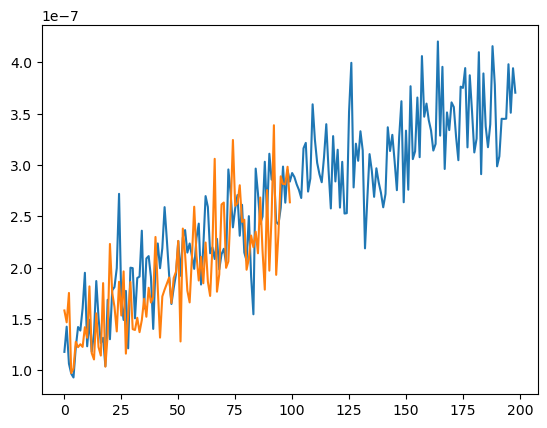

In [11]:
# Compute variance
var_diff_shape = torch.zeros_like(ref_grad_shape)
var_diff_exp = torch.zeros_like(ref_grad_exp)
for s, e in saved_values:
    var_diff_shape += torch.square(s - ref_grad_shape)
    var_diff_exp += torch.square(e - ref_grad_exp)
var_diff_shape /= len(saved_values)
var_diff_exp /= len(saved_values)
print(saved_values[0][0].shape)
plt.plot(range(saved_values[0][0].shape[1]), var_diff_shape[0].numpy())
plt.plot(range(saved_values[0][1].shape[1]), var_diff_exp[0].numpy())
plt.show()

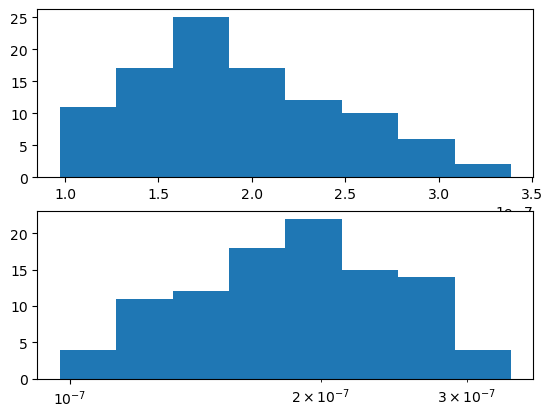

In [12]:
import numpy as np
def show_hist(x):
    # histogram on linear scale
    plt.subplot(211)
    hist, bins, _ = plt.hist(x, bins=8)

    # histogram on log scale. 
    # Use non-equal bin sizes, such that they look equal on log scale.
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.show()

show_hist(var_diff_exp.numpy()[0])

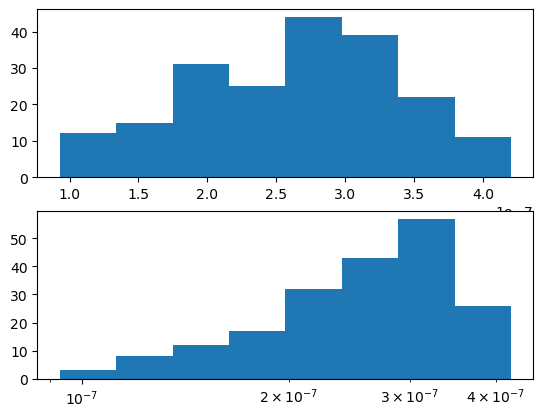

In [13]:
show_hist(var_diff_shape.numpy()[0])